In [1]:
import os
import numpy as np
from PIL import Image
# import splitfolders
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
# splitfolders.ratio("selected_dataset", output="output", seed=1337, ratio=(.8, .1, .1))

In [3]:
dataset = ImageFolder(root='selected_dataset',                   # 다운로드 받은 폴더의 root 경로를 지정합니다.
                      transform=transforms.Compose([
                          transforms.ToTensor(), 
                      ]))

data_loader = DataLoader(dataset, 
                         batch_size=32, 
                         shuffle=True,
                        #  num_workers=8
                        )

In [4]:
dataset.classes

['L2_10',
 'L2_12',
 'L2_15',
 'L2_20',
 'L2_21',
 'L2_24',
 'L2_25',
 'L2_27',
 'L2_3',
 'L2_30',
 'L2_33',
 'L2_34',
 'L2_39',
 'L2_40',
 'L2_41',
 'L2_44',
 'L2_45',
 'L2_46',
 'L2_50',
 'L2_52']

In [5]:
images, labels = next(iter(data_loader))

In [6]:
images[0].shape

torch.Size([3, 100, 100])

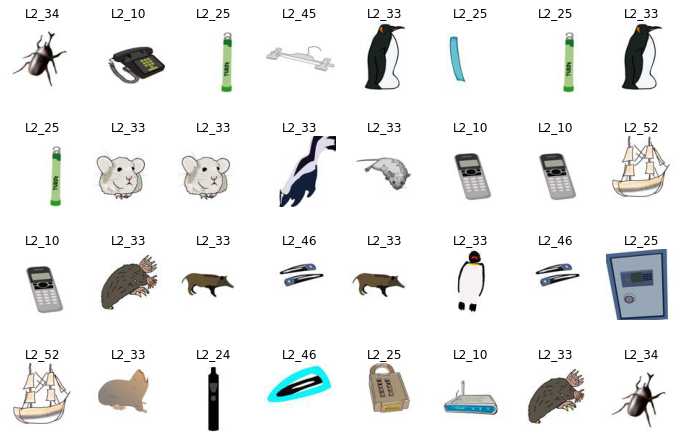

In [7]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in dataset.class_to_idx.items()}
# print(labels_map)
figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 입니다.
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화합니다.
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

## Image Augmentation

In [8]:
# Image Transform을 지정합니다.
image_transform = transforms.Compose([
    # transforms.Resize(),                # Resize (300 X 300) -> (224, 224) 크기 조정
    transforms.RandomHorizontalFlip(0.5),  # 50% 확률로 Horizontal Flip
    transforms.ToTensor(),                 # Tensor 변환 (정규화)
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [9]:
# 이미지 폴더로부터 데이터를 로드합니다.
dataset = ImageFolder(root='selected_dataset',            # 다운로드 받은 폴더의 root 경로를 지정합니다.
                      transform=image_transform) # Image Augmentation 적용      

In [10]:
# Image Augmentation 이 적용된 DataLoader를 로드 합니다.
data_loader = DataLoader(dataset, 
                         batch_size=256, 
                         shuffle=True,
                         num_workers=8
                        )

# 1개의 배치를 추출합니다.
images, labels = next(iter(data_loader))

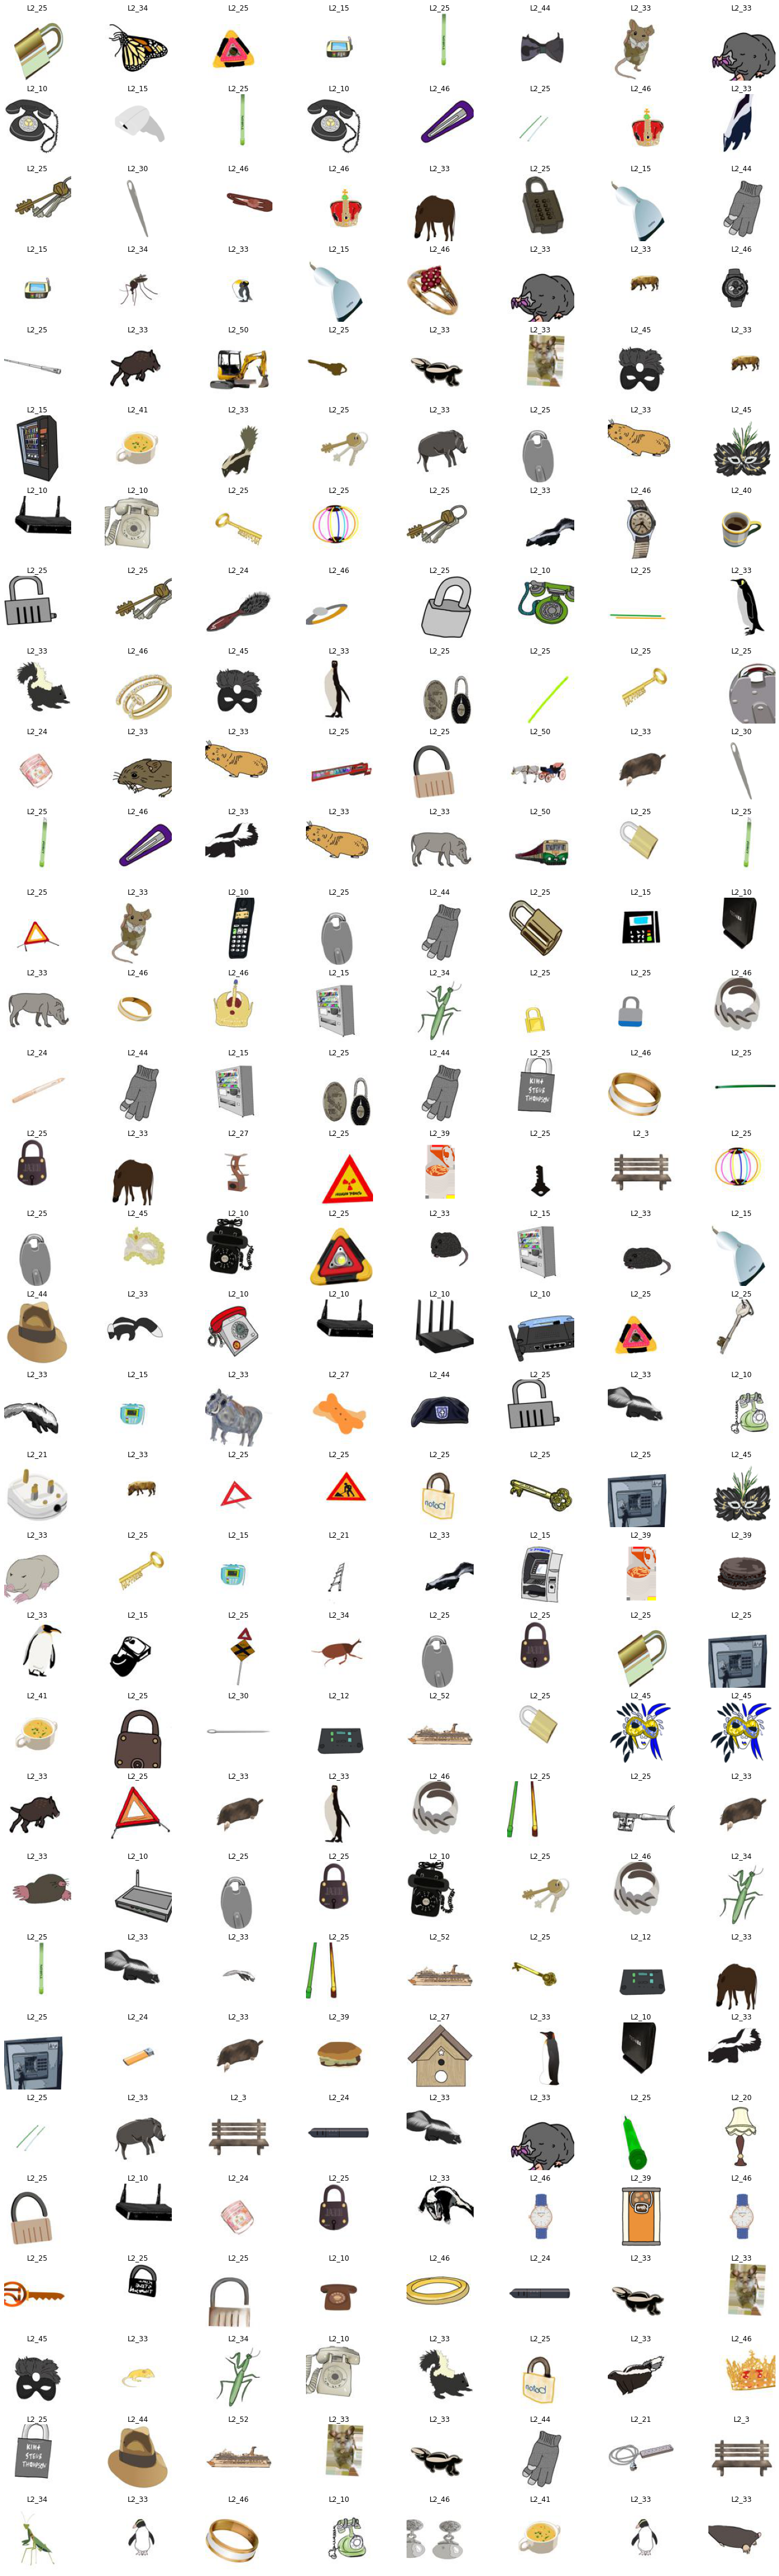

In [25]:
# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in dataset.class_to_idx.items()}
figure = plt.figure(figsize=(24, 80))
cols, rows = 8, 32

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")

    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [26]:
from torch.utils.data import random_split


ratio = 0.8 # 학습셋(train set)의 비율을 설정합니다.

train_size = int(ratio * len(dataset))
test_size = len(dataset) - train_size
print(f'total: {len(dataset)}\ntrain_size: {train_size}\ntest_size: {test_size}')

# random_split으로 8:2의 비율로 train / test 세트를 분할합니다.
train_data, test_data = random_split(dataset, [train_size, test_size])

total: 23320
train_size: 18656
test_size: 4664


In [13]:
batch_size = 256 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=num_workers
                         )
test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False, 
                         num_workers=num_workers
                        )

In [14]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([256, 3, 100, 100]), torch.Size([256]))

In [15]:
# 1개의 이미지의 shape를 확인합니다.
# 224 X 224 RGB 이미지가 잘 로드 되었음을 확인합니다.
images[0].shape

torch.Size([3, 100, 100])

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# device = torch.device("mps")

cpu


In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(3*3*128, 20)
    
    def forward(self, x):
        x = self.sequential(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x        

In [18]:
model = CNN() # Model 생성
model.to(device)  

CNN(
  (sequential): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=20, bias=True)
)

In [19]:
from torchsummary import summary

summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             896
              ReLU-2         [-1, 32, 100, 100]               0
         MaxPool2d-3           [-1, 32, 50, 50]               0
            Conv2d-4           [-1, 64, 50, 50]          18,496
              ReLU-5           [-1, 64, 50, 50]               0
         MaxPool2d-6           [-1, 64, 25, 25]               0
            Conv2d-7           [-1, 64, 25, 25]          36,928
              ReLU-8           [-1, 64, 25, 25]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10          [-1, 128, 12, 12]          73,856
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 128, 6, 6]         147,584
             ReLU-14            [-1, 12

In [20]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [21]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)

        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc


In [22]:

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
             # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [23]:
# 최대 Epoch을 지정합니다.
num_epochs = 10

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in tqdm(range(num_epochs)):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

 10%|█         | 1/10 [27:30<4:07:33, 1650.36s/it]

[INFO] val_loss has been improved from inf to 2.25075. Saving Model!
epoch 01, loss: 2.54935, acc: 0.28623, val_loss: 2.25075, val_accuracy: 0.29588


 20%|██        | 2/10 [3:13:27<14:31:33, 6536.63s/it]

[INFO] val_loss has been improved from 2.25075 to 2.04775. Saving Model!
epoch 02, loss: 2.14813, acc: 0.36005, val_loss: 2.04775, val_accuracy: 0.39280


 30%|███       | 3/10 [4:30:12<10:59:42, 5654.71s/it]

epoch 03, loss: 2.17764, acc: 0.35919, val_loss: 2.05922, val_accuracy: 0.34112


 40%|████      | 4/10 [14:10:40<28:37:12, 17172.10s/it]

[INFO] val_loss has been improved from 2.04775 to 1.94844. Saving Model!
epoch 04, loss: 2.01016, acc: 0.38910, val_loss: 1.94844, val_accuracy: 0.41681


 50%|█████     | 5/10 [14:17:00<15:26:23, 11116.70s/it]

[INFO] val_loss has been improved from 1.94844 to 1.73039. Saving Model!
epoch 05, loss: 1.81849, acc: 0.45208, val_loss: 1.73039, val_accuracy: 0.49593


 60%|██████    | 6/10 [14:23:42<8:18:13, 7473.49s/it]  

epoch 06, loss: 1.82130, acc: 0.45181, val_loss: 1.81468, val_accuracy: 0.46205


 70%|███████   | 7/10 [14:28:31<4:16:14, 5124.68s/it]

epoch 07, loss: 1.61197, acc: 0.51855, val_loss: 1.73211, val_accuracy: 0.49121


 80%|████████  | 8/10 [14:34:47<2:00:26, 3613.22s/it]

epoch 08, loss: 1.77439, acc: 0.46886, val_loss: 2.02628, val_accuracy: 0.40159


 90%|█████████ | 9/10 [14:40:17<43:06, 2586.83s/it]  

[INFO] val_loss has been improved from 1.73039 to 1.59077. Saving Model!
epoch 09, loss: 1.80056, acc: 0.45283, val_loss: 1.59077, val_accuracy: 0.51887


100%|██████████| 10/10 [14:46:08<00:00, 5316.84s/it]

epoch 10, loss: 1.49824, acc: 0.55317, val_loss: 1.85544, val_accuracy: 0.41509


In [24]:
model.load_state_dict(torch.load('DNNModel.pth'))


# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 1.59760, evaluation accuracy: 0.52637
